# CSCI 5622 Fall 2017 HW#3
## Brian McKean
### Code

In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
plt.style.use('ggplot')
%matplotlib inline
from collections import defaultdict
import seaborn as sns
import pandas as pd

In [2]:
import seaborn as sns
from pydataset import data

In [3]:
import numpy as np
import pickle, gzip
import matplotlib.pyplot as plt

In [4]:
class Network:
    def __init__(self, sizes):
        self.L = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(n, 1) for n in self.sizes[1:]]
        self.weights = [np.random.randn(n, m) for (m,n) in zip(self.sizes[:-1], self.sizes[1:])]
        self.epoch_results = []

    def g(self, z):
        """
        activation function
        """
        return sigmoid(z)

    def g_prime(self, z):
        """
        derivative of activation function
        """
        return sigmoid_prime(z)

    def forward_prop(self, a):
        """
        memory aware forward propagation for testing
        only.  back_prop implements it's own forward_prop
        """
        for (W,b) in zip(self.weights, self.biases):
            a = self.g(np.dot(W, a) + b)
        return a

    def gradC(self, a, y):
        """
        gradient of cost function
        Assumes C(a,y) = (a-y)^2/2
        """
        return (a - y)
    
    def SGD_train(self, train, epochs, eta, lam=0.0, verbose=True, test=None):
        """
        SGD for training parameters
        epochs is the number of epocs to run
        eta is the learning rate
        lam is the regularization parameter
        If verbose is set will print progressive accuracy updates
        If test set is provided, routine will print accuracy on test set as learning evolves
        """
        n_train = len(train)
        #print ("train shape", np.array(train).shape)
        for epoch in range(epochs):
            perm = np.random.permutation(n_train)
            for kk in range(n_train):
                xk = train[perm[kk]][0]
                yk = train[perm[kk]][1]
                #print ("xk, yK", np.array(xk.shape), np.array(yk).shape)
                dWs, dbs = self.back_prop(xk, yk)
                # TODO: Add L2-regularization
                #self.weights = [W - eta*dW - lam*W  for (W, dW) in zip(self.weights, dWs)]
                self.weights = [W - eta*(dW  + lam*W) for (W, dW) in zip(self.weights, dWs)]
                self.biases = [b - eta*db  for (b, db) in zip(self.biases, dbs)]
            if verbose:
                if epoch==0 or (epoch + 1) % 15 == 0:
                    acc_train = self.evaluate(train)
                    if test is not None:
                        acc_test = self.evaluate(test)
                        print("Epoch {:4d}: Train {:10.5f}, Test {:10.5f}".format(epoch+1, acc_train, acc_test))
                        self.epoch_results.append((epoch+1, acc_train, acc_test))
                    else:
                        print("Epoch {:4d}: Train {:10.5f}".format(epoch+1, acc_train))
                        elf.epoch_results.append((epoch+1, acc_train))
        return acc_train

    def back_prop(self, x, y):
        """
        Back propagation for derivatives of C wrt parameters
        """
        db_list = [np.zeros(b.shape) for b in self.biases]
        dW_list = [np.zeros(W.shape) for W in self.weights]


        a = x
        a_list = [a]
        z_list = [np.zeros(a.shape)] # Pad with throwaway so indices match
        for W, b in zip(self.weights, self.biases):
            #print ("here", np.array(W).shape, np.array( a).shape, np.array(b).shape, "done")
            z = np.dot(W, a) + b
            z_list.append(z)
            a = self.g(z)
            a_list.append(a)

        # Back propagate deltas to compute derivatives
        # TODO delta  =
        # Last layer
        delta  =  self.g_prime(z) * self.gradC(a, y)
        #print (a, delta, np.ones((len(a),1)), np.ones(len(a)) - a , a-y)
        #print (a.shape, delta.shape, np.ones((len(a),1)).shape, (np.ones(len(a)) - a).shape , (a-y).shape )
        for ell in range(self.L-2,-1,-1):
            #print ("Ell", ell)
            # TODO db_list[ell] =
            #print (db_list[ell].shape, db_list[ell])
            db_list[ell] = delta
            #print (db_list[ell].shape, db_list[ell])
            # TODO dW_list[ell] =
            #print (dW_list[ell].shape, dW_list[ell])
            #dW_list[ell] = delta *  a_list[ell].T
            dW_list[ell] = delta.dot( a_list[ell].T )
            #print ("dW shape", dW_list[ell].shape, "dW", dW_list[ell], "W", self.weights)
            # TODO delta = self.weights[ell].T*delta * h
            #delta = self.weights[ell].T*delta* (a_list[ell] - y)
            delta = np.dot(self.weights[ell].T, delta )*( self.g_prime(z_list[ell]))

            #print (delta.shape, delta)
        #exit(0)
        return (dW_list, db_list)

    def evaluate(self, test):
        """
        Evaluate current model on labeled test data
        """
        ctr = 0
        for x, y in test:
            yhat = self.forward_prop(x)
            ctr += np.argmax(yhat) == np.argmax(y)
        return float(ctr) / float(len(test))

    def compute_cost(self, x, y):
        """
        Evaluate the cost function for a specified
        training example.
        """
        a = self.forward_prop(x)
        return 0.5*np.linalg.norm(a-y)**2
    
    def get_epoch_results(self):
        return self.epoch_results


In [5]:

def sigmoid(z, threshold=20):
    z = np.clip(z, -threshold, threshold)
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z) * (1.0 - sigmoid(z))

def mnist_digit_show(flatimage, outname=None):

    import matplotlib.pyplot as plt

    image = np.reshape(flatimage, (-1,14))

    plt.matshow(image, cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    if outname:
        plt.savefig(outname)
    else:
        plt.show()


In [6]:
#f = gzip.open('../data/tinyTOY.pkl.gz', 'rb') # change path to ../data/tinyMNIST.pkl.gz after debugging
f = gzip.open('../data/tinyMNIST.pkl.gz', 'rb')
u = pickle._Unpickler(f)
u.encoding = 'latin1'
train, test = u.load()

#nn = Network([2,30,2])
nn = Network([196,30,10])
nn.SGD_train(train, epochs=100, eta=0.01, lam=0.001, verbose=True, test=test)

Epoch    1: Train    0.09444, Test    0.07843
Epoch   15: Train    0.60064, Test    0.52381
Epoch   30: Train    0.80072, Test    0.69348
Epoch   45: Train    0.84354, Test    0.77351
Epoch   60: Train    0.86635, Test    0.80152
Epoch   75: Train    0.86955, Test    0.80752
Epoch   90: Train    0.87955, Test    0.80912


0.8795518207282913

In [7]:
### Plot accuracy versus hidden layer

In [8]:
acc_results_nodes = []
acc_results_acc_test = []
acc_results_acc_train = []

In [9]:
for num_nodes in range (10, 41, 5):
    print ("Num nodes", num_nodes)
    nn = Network([196,num_nodes,10])
    acc_results_acc_train.append(nn.SGD_train(train, epochs=100, eta=0.01, lam=0.001, verbose=True, test=test))
    acc_results_nodes.append(num_nodes)
    acc_results_acc_test.append(nn.evaluate(test))
    

Num nodes 10
Epoch    1: Train    0.12925, Test    0.11685
Epoch   15: Train    0.34814, Test    0.33573
Epoch   30: Train    0.53341, Test    0.51461
Epoch   45: Train    0.61985, Test    0.58703
Epoch   60: Train    0.76991, Test    0.70468
Epoch   75: Train    0.82833, Test    0.75350
Epoch   90: Train    0.85914, Test    0.77911
Num nodes 15
Epoch    1: Train    0.12725, Test    0.08283
Epoch   15: Train    0.50300, Test    0.46899
Epoch   30: Train    0.65746, Test    0.60864
Epoch   45: Train    0.80912, Test    0.71989
Epoch   60: Train    0.85034, Test    0.76911
Epoch   75: Train    0.86595, Test    0.79672
Epoch   90: Train    0.87155, Test    0.80712
Num nodes 20
Epoch    1: Train    0.17047, Test    0.19328
Epoch   15: Train    0.62265, Test    0.56663
Epoch   30: Train    0.79192, Test    0.72709
Epoch   45: Train    0.84714, Test    0.78752
Epoch   60: Train    0.86234, Test    0.80232
Epoch   75: Train    0.87075, Test    0.80912
Epoch   90: Train    0.87675, Test    0.8

In [10]:
print (acc_results_nodes, acc_results_acc_train, acc_results_acc_test)

[10, 15, 20, 25, 30, 35, 40] [0.8591436574629852, 0.8715486194477791, 0.876750700280112, 0.8795518207282913, 0.8815526210484194, 0.8803521408563425, 0.8783513405362144] [0.7943177270908364, 0.8119247699079631, 0.8159263705482193, 0.8107242897158864, 0.8115246098439376, 0.8135254101640657, 0.8103241296518607]


In [11]:
acc_results_nodes = np.array(acc_results_nodes)
acc_results_acc_train = np.array(acc_results_acc_train)
acc_results_acc_test = np.array(acc_results_acc_test)

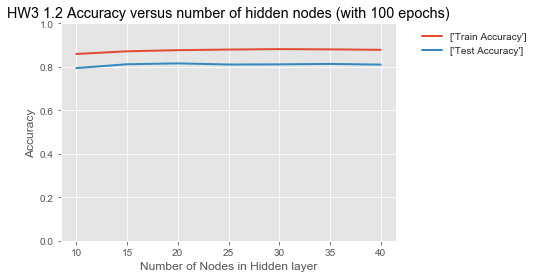

In [12]:

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
sns.set_style("whitegrid")

x = acc_results_nodes
y2 = acc_results_acc_test
y1 = acc_results_acc_train


line, = ax.plot(x, y1 , lw=2, label=['Train Accuracy'])
line, = ax.plot(x, y2 , lw=2, label=['Test Accuracy'])





ax.set_xlabel('Number of Nodes in Hidden layer')
ax.set_ylabel('Accuracy')

      
ax.set_ylim(0,1.00)



plt.title('HW3 1.2 Accuracy versus number of hidden nodes (with 100 epochs)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()
plt.clf()
plt.close(fig)

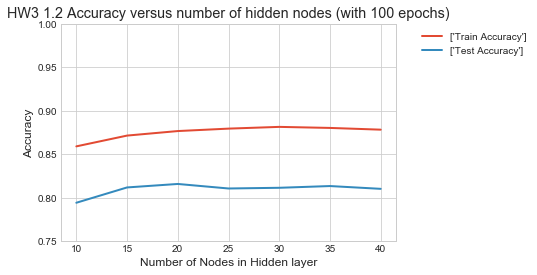

In [17]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
sns.set_style("whitegrid")

x = acc_results_nodes
y2 = acc_results_acc_test
y1 = acc_results_acc_train


line, = ax.plot(x, y1 , lw=2, label=['Train Accuracy'])
line, = ax.plot(x, y2 , lw=2, label=['Test Accuracy'])





ax.set_xlabel('Number of Nodes in Hidden layer')
ax.set_ylabel('Accuracy')

      
ax.set_ylim(0.75,1.00)



plt.title('HW3 1.2 Accuracy versus number of hidden nodes (with 100 epochs)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()
plt.clf()
plt.close(fig)

In [19]:
nn = Network([196,30,10])
nn.SGD_train(train, epochs=100, eta=0.01, lam=0.001, verbose=True, test=test)

Epoch    1: Train    0.13365, Test    0.14606
Epoch   15: Train    0.48179, Test    0.43778
Epoch   30: Train    0.79112, Test    0.71749
Epoch   45: Train    0.83393, Test    0.77431
Epoch   60: Train    0.86395, Test    0.79472
Epoch   75: Train    0.87195, Test    0.81192
Epoch   90: Train    0.87795, Test    0.81553


0.8779511804721889

In [20]:
epoch_results = nn.get_epoch_results()
x_epochs = []
y_test_acc = []
y_train_acc = []
for x, y1, y2 in epoch_results:
    x_epochs.append(x)
    y_train_acc.append(y1)
    y_test_acc.append(y2)
    
y30_test = list(y_test_acc)
y30_train = list(y_train_acc)

In [21]:
nn = Network([196,20,10])
nn.SGD_train(train, epochs=100, eta=0.01, lam=0.001, verbose=True, test=test)

Epoch    1: Train    0.12645, Test    0.14326
Epoch   15: Train    0.49300, Test    0.44378
Epoch   30: Train    0.74070, Test    0.68868
Epoch   45: Train    0.81353, Test    0.74870
Epoch   60: Train    0.84594, Test    0.78631
Epoch   75: Train    0.86715, Test    0.79952
Epoch   90: Train    0.87435, Test    0.80752


0.8743497398959584

In [22]:
epoch_results = nn.get_epoch_results()
x_epochs = []
y_test_acc = []
y_train_acc = []
for x, y1, y2 in epoch_results:
    x_epochs.append(x)
    y_train_acc.append(y1)
    y_test_acc.append(y2)
    
y20_test = y_test_acc
y20_train = y_train_acc

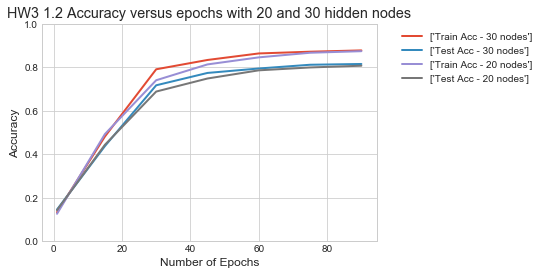

In [23]:


plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
sns.set_style("whitegrid")

x = x_epochs


line1, = ax.plot(x, y30_train , lw=2, label=['Train Acc - 30 nodes'])


line2, = ax.plot(x, y30_test , lw=2, label=['Test Acc - 30 nodes'])


line4, = ax.plot(x, y20_train , lw=2, label=['Train Acc - 20 nodes'])


line5, = ax.plot(x, y20_test , lw=2, label=['Test Acc - 20 nodes'])

ax.set_ylim(0,1.00)

ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Accuracy')


plt.title('HW3 1.2 Accuracy versus epochs with 20 and 30 hidden nodes')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()
plt.clf()
plt.close(fig)
    

In [25]:
results = pd.read_csv('rnn_tests.csv')

In [29]:
print results

,num_words,example_len,batch_size,embedding_len,lstm_units_1,Best Accuracy,Epoch of 3 for best
0,5000,128,32,64,128,0.8624,2
1,5000,256,32,64,128,0.8676,2
2,5000,512,32,64,128,0.8664,2
3,5000,768,32,64,128,0.8671,3
4,5000,1024,32,64,128,0.8682,2
5,1000,512,32,64,128,0.8490,3
6,2500,512,32,64,128,0.8622,2
7,5000,512,32,64,128,0.8707,3
8,7500,512,32,64,128,0.8613,3
9,10000,512,32,64,128,0.8519,3
